### Multiclass Support Vector Machines
In this exercise you will:
- implement a fully-vectorized loss function for the mulri-class SVM
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned parameters

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### CIFAR-10 Data Loading and Preprocessing
Open up a terminal window and navigate to the datasets folder inside the hw3 folder. Run the get_datasets.sh script. On my Mac, I just type in ./get_datasets.sh at the shell prompt. A new folder called cifar_10_batches_py will be created and it will contain 50000 labeled images for training and  10000 labeled images for testing. The function further partitions the  50000 training images into a train set and a validation set for selection of hyperparameters. We have provided a function to read this data in **data_utils.py**. Each image is a  32×32
array of RGB triples. It is preprocessed by subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size 3072 (i.e.,  32×32×3). Then a 1 is appended to the front of that vector to handle the intercept term. So the training set is a numpy matrix of size  49000×3073, the validation set is a matrix of size  1000×3073 and the set-aside test set is of size  10000×3073. We also have a random sample of 500 images from the training data to serve as a development set or dev set to test our gradient and loss function implementations.

In [2]:
import data_utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_dev, y_dev, X_test, y_test = data_utils.get_CIFAR10_data()

Train data shape: 49000,32,32,3
Train labels shape: 49000
Validation data shape: 1000,32,32,3
Validation labels shape: 1000
Test data shape: 10000,32,32,3
Test labels shape: 10000
Training data shape: (49000, 3072)
Validation data shape: (1000, 3072)
Test data shape: (10000, 3072)
dev data shape: (500, 3072)
Training data shape with bias term: (49000, 3073) 
Validation data shape with bias term: (1000, 3073)
Test data shape with bias term: (10000, 3073)
Devset data shape with bias term: (500, 3073)


### SVM Classifier
Your code for this section will all be written inside **linear_svm.py**.
You will need to write the function **naive_loss_svm** which uses for loops to evaluate the multiclass SVM loss function.

In [98]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM coefficient matrix of small numbers
theta = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(theta, X_train, y_train, 0.00001)
print('loss: %f' % (loss, ))
print('grad: %s', grad)

loss: 8.871508
grad: %s [[-1.38578996e+01 -7.32900217e+00  6.67964223e+00 ...  1.50112795e+00
  -1.73184960e+01 -3.45113112e+01]
 [-2.48680253e+01 -3.59733360e+00  6.37004594e+00 ...  8.01020585e-01
  -2.81762448e+01 -3.93722443e+01]
 [-4.55546541e+01 -4.92771731e+00  1.89680818e+01 ...  1.89338387e+00
  -4.73295932e+01 -5.02944001e+01]
 ...
 [-1.04844087e+01 -5.72919794e+00  1.06471181e+00 ... -4.84073409e+00
   1.46550937e+01 -8.37450362e+00]
 [-2.38707612e+01 -1.22044986e+01  9.08829377e+00 ...  1.02263383e+01
  -4.64128523e+00 -1.26129868e+01]
 [-4.73469388e-03  1.74897959e-02 -9.77551020e-03 ... -2.01020408e-02
   1.12244898e-03  2.26530612e-03]]


The grad returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **svm_loss_naive**. You will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you.

In [99]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at theta.
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda th: svm_loss_naive(th, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(theta, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

numerical: -39.101261 analytic: -39.101261, relative error: 1.998905e-13
numerical: -0.856579 analytic: -0.856579, relative error: 1.139178e-10
numerical: 30.605838 analytic: 30.605838, relative error: 1.718065e-11
numerical: -9.787998 analytic: -9.787998, relative error: 5.822161e-12
numerical: -14.475856 analytic: -14.475856, relative error: 1.941268e-11
numerical: 18.600278 analytic: 18.600278, relative error: 6.379318e-12
numerical: -6.404367 analytic: -6.404367, relative error: 1.417280e-11
numerical: 13.484767 analytic: 13.484767, relative error: 1.062928e-11
numerical: -13.686943 analytic: -13.686943, relative error: 5.925389e-12
numerical: 1.489670 analytic: 1.489670, relative error: 1.667743e-10
numerical: 21.236046 analytic: 21.236046, relative error: 1.707987e-11
numerical: 3.045923 analytic: 3.037086, relative error: 1.452609e-03
numerical: -19.112995 analytic: -19.112995, relative error: 6.349179e-12
numerical: -14.929558 analytic: -14.929558, relative error: 8.424024e-12


In [100]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.893875e+00 computed in 0.218619s
Vectorized loss: 8.893875e+00 computed in 0.008125s
Difference: 0.000000


### Vectorized version of the gradient computation
Complete the implementation of svm_loss_vectorized, and compute the gradient
of the loss function in a vectorized way.



In [101]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Difference: %f' % difference)

Naive loss and gradient: computed in 0.255304s
Vectorized loss and gradient: computed in 0.008016s
Difference: 0.000000


In [126]:
# In the file linear_classifier.py, we have implemented SGD in the function
# LinearClassifier.train() and you can run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=10000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 10000: loss 26.618595
iteration 100 / 10000: loss 14.439011
iteration 200 / 10000: loss 13.488455
iteration 300 / 10000: loss 12.027221
iteration 400 / 10000: loss 12.367723
iteration 500 / 10000: loss 11.186860
iteration 600 / 10000: loss 10.267229
iteration 700 / 10000: loss 10.190869
iteration 800 / 10000: loss 11.475372
iteration 900 / 10000: loss 10.742176
iteration 1000 / 10000: loss 11.304327
iteration 1100 / 10000: loss 10.402386
iteration 1200 / 10000: loss 9.495934
iteration 1300 / 10000: loss 10.252024
iteration 1400 / 10000: loss 9.290487
iteration 1500 / 10000: loss 10.280694
iteration 1600 / 10000: loss 8.929802
iteration 1700 / 10000: loss 10.146641
iteration 1800 / 10000: loss 9.147179
iteration 1900 / 10000: loss 8.958841
iteration 2000 / 10000: loss 8.824701
iteration 2100 / 10000: loss 9.440031
iteration 2200 / 10000: loss 8.434980
iteration 2300 / 10000: loss 8.623048
iteration 2400 / 10000: loss 8.551723
iteration 2500 / 10000: loss 9.947398
iteration

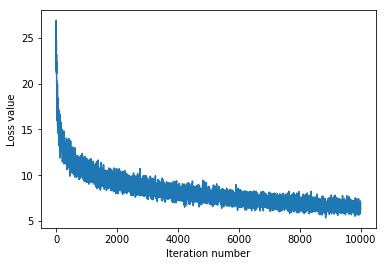

In [127]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Prediction with an SVM
Compute $\theta^T  x$ for a new example $x$ and pick the class with the highest score.

In [128]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.385184
validation accuracy: 0.391000


In [129]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.38 or higher on the validation set.

learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_lr = None
best_reg = None

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from linear_classifier import LinearSVM
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=10000, verbose=True)
        train_accuracy = np.mean(y_train == svm.predict(X_train)) 
        val_accuracy = np.mean(y_val == svm.predict(X_val))
        results[(lr,reg)] = (train_accuracy,val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            best_lr = lr
            best_reg = reg


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 10000: loss 26.480972
iteration 100 / 10000: loss 18.214898
iteration 200 / 10000: loss 15.160438
iteration 300 / 10000: loss 12.442440
iteration 400 / 10000: loss 14.217034
iteration 500 / 10000: loss 13.807940
iteration 600 / 10000: loss 13.938920
iteration 700 / 10000: loss 12.899570
iteration 800 / 10000: loss 12.868282
iteration 900 / 10000: loss 10.966838
iteration 1000 / 10000: loss 12.584683
iteration 1100 / 10000: loss 10.733297
iteration 1200 / 10000: loss 9.956961
iteration 1300 / 10000: loss 9.687831
iteration 1400 / 10000: loss 11.582995
iteration 1500 / 10000: loss 11.968219
iteration 1600 / 10000: loss 9.663429
iteration 1700 / 10000: loss 11.330394
iteration 1800 / 10000: loss 12.694792
iteration 1900 / 10000: loss 10.162600
iteration 2000 / 10000: loss 10.935198
iteration 2100 / 10000: loss 9.911433
iteration 2200 / 10000: loss 10.376710
iteration 2300 / 10000: loss 11.122637
iteration 2400 / 10000: loss 9.909854
iteration 2500 / 10000: loss 9.880952
iter

iteration 1400 / 10000: loss 17.424039
iteration 1500 / 10000: loss 17.641718
iteration 1600 / 10000: loss 17.118256
iteration 1700 / 10000: loss 15.987633
iteration 1800 / 10000: loss 17.708210
iteration 1900 / 10000: loss 16.134013
iteration 2000 / 10000: loss 17.469254
iteration 2100 / 10000: loss 16.378144
iteration 2200 / 10000: loss 16.266830
iteration 2300 / 10000: loss 16.805799
iteration 2400 / 10000: loss 16.758273
iteration 2500 / 10000: loss 15.792534
iteration 2600 / 10000: loss 15.978254
iteration 2700 / 10000: loss 15.458252
iteration 2800 / 10000: loss 15.818729
iteration 2900 / 10000: loss 16.135744
iteration 3000 / 10000: loss 17.423810
iteration 3100 / 10000: loss 16.357724
iteration 3200 / 10000: loss 15.705269
iteration 3300 / 10000: loss 16.053648
iteration 3400 / 10000: loss 15.739877
iteration 3500 / 10000: loss 15.774248
iteration 3600 / 10000: loss 16.342616
iteration 3700 / 10000: loss 14.374467
iteration 3800 / 10000: loss 15.864675
iteration 3900 / 10000: l

iteration 2600 / 10000: loss 5.799611
iteration 2700 / 10000: loss 8.102040
iteration 2800 / 10000: loss 7.597913
iteration 2900 / 10000: loss 8.133001
iteration 3000 / 10000: loss 7.545656
iteration 3100 / 10000: loss 6.821571
iteration 3200 / 10000: loss 6.530091
iteration 3300 / 10000: loss 7.079660
iteration 3400 / 10000: loss 7.439174
iteration 3500 / 10000: loss 7.126122
iteration 3600 / 10000: loss 5.923241
iteration 3700 / 10000: loss 6.627648
iteration 3800 / 10000: loss 7.887077
iteration 3900 / 10000: loss 5.128227
iteration 4000 / 10000: loss 6.803417
iteration 4100 / 10000: loss 6.935924
iteration 4200 / 10000: loss 6.260000
iteration 4300 / 10000: loss 7.115436
iteration 4400 / 10000: loss 6.845777
iteration 4500 / 10000: loss 6.882251
iteration 4600 / 10000: loss 5.991666
iteration 4700 / 10000: loss 6.826105
iteration 4800 / 10000: loss 6.420608
iteration 4900 / 10000: loss 6.950756
iteration 5000 / 10000: loss 6.499458
iteration 5100 / 10000: loss 6.579948
iteration 52

iteration 4100 / 10000: loss 11.771415
iteration 4200 / 10000: loss 11.448204
iteration 4300 / 10000: loss 11.586272
iteration 4400 / 10000: loss 12.012845
iteration 4500 / 10000: loss 11.330740
iteration 4600 / 10000: loss 10.381318
iteration 4700 / 10000: loss 10.781805
iteration 4800 / 10000: loss 11.033657
iteration 4900 / 10000: loss 11.601840
iteration 5000 / 10000: loss 10.379735
iteration 5100 / 10000: loss 11.223234
iteration 5200 / 10000: loss 10.080009
iteration 5300 / 10000: loss 11.231621
iteration 5400 / 10000: loss 10.701805
iteration 5500 / 10000: loss 10.257614
iteration 5600 / 10000: loss 11.180459
iteration 5700 / 10000: loss 11.250466
iteration 5800 / 10000: loss 11.575728
iteration 5900 / 10000: loss 11.429257
iteration 6000 / 10000: loss 10.532237
iteration 6100 / 10000: loss 10.932676
iteration 6200 / 10000: loss 10.196947
iteration 6300 / 10000: loss 10.501589
iteration 6400 / 10000: loss 10.746105
iteration 6500 / 10000: loss 10.545469
iteration 6600 / 10000: l

iteration 5500 / 10000: loss 5.557348
iteration 5600 / 10000: loss 5.236188
iteration 5700 / 10000: loss 5.299742
iteration 5800 / 10000: loss 5.555031
iteration 5900 / 10000: loss 5.442916
iteration 6000 / 10000: loss 5.476158
iteration 6100 / 10000: loss 5.555812
iteration 6200 / 10000: loss 4.859112
iteration 6300 / 10000: loss 5.370203
iteration 6400 / 10000: loss 6.011120
iteration 6500 / 10000: loss 5.734685
iteration 6600 / 10000: loss 5.349013
iteration 6700 / 10000: loss 5.599405
iteration 6800 / 10000: loss 5.713882
iteration 6900 / 10000: loss 5.140062
iteration 7000 / 10000: loss 5.860234
iteration 7100 / 10000: loss 5.753660
iteration 7200 / 10000: loss 5.543563
iteration 7300 / 10000: loss 4.994707
iteration 7400 / 10000: loss 5.585731
iteration 7500 / 10000: loss 5.945422
iteration 7600 / 10000: loss 5.148878
iteration 7700 / 10000: loss 5.512555
iteration 7800 / 10000: loss 5.465827
iteration 7900 / 10000: loss 5.588115
iteration 8000 / 10000: loss 4.974930
iteration 81

iteration 7000 / 10000: loss 8.612085
iteration 7100 / 10000: loss 7.741269
iteration 7200 / 10000: loss 8.284682
iteration 7300 / 10000: loss 8.105184
iteration 7400 / 10000: loss 8.125266
iteration 7500 / 10000: loss 7.201063
iteration 7600 / 10000: loss 7.108627
iteration 7700 / 10000: loss 7.837076
iteration 7800 / 10000: loss 8.541173
iteration 7900 / 10000: loss 7.354195
iteration 8000 / 10000: loss 7.586029
iteration 8100 / 10000: loss 7.551488
iteration 8200 / 10000: loss 7.412282
iteration 8300 / 10000: loss 7.212303
iteration 8400 / 10000: loss 7.181626
iteration 8500 / 10000: loss 7.334012
iteration 8600 / 10000: loss 7.337878
iteration 8700 / 10000: loss 7.707233
iteration 8800 / 10000: loss 6.864780
iteration 8900 / 10000: loss 7.809490
iteration 9000 / 10000: loss 7.529607
iteration 9100 / 10000: loss 7.117171
iteration 9200 / 10000: loss 6.824486
iteration 9300 / 10000: loss 7.074592
iteration 9400 / 10000: loss 7.068644
iteration 9500 / 10000: loss 6.921109
iteration 96

iteration 8600 / 10000: loss 5.302440
iteration 8700 / 10000: loss 4.653980
iteration 8800 / 10000: loss 4.401531
iteration 8900 / 10000: loss 4.744666
iteration 9000 / 10000: loss 4.672549
iteration 9100 / 10000: loss 4.117107
iteration 9200 / 10000: loss 4.518776
iteration 9300 / 10000: loss 4.390407
iteration 9400 / 10000: loss 4.054292
iteration 9500 / 10000: loss 5.058075
iteration 9600 / 10000: loss 3.915371
iteration 9700 / 10000: loss 4.264790
iteration 9800 / 10000: loss 4.543982
iteration 9900 / 10000: loss 4.406576
iteration 0 / 10000: loss 26.524999
iteration 100 / 10000: loss 11.805703
iteration 200 / 10000: loss 10.615627
iteration 300 / 10000: loss 9.864299
iteration 400 / 10000: loss 9.905318
iteration 500 / 10000: loss 8.917674
iteration 600 / 10000: loss 8.385453
iteration 700 / 10000: loss 8.010138
iteration 800 / 10000: loss 7.898533
iteration 900 / 10000: loss 8.155209
iteration 1000 / 10000: loss 7.732162
iteration 1100 / 10000: loss 8.223350
iteration 1200 / 1000

iteration 200 / 10000: loss 30.159407
iteration 300 / 10000: loss 23.365379
iteration 400 / 10000: loss 18.473475
iteration 500 / 10000: loss 14.761281
iteration 600 / 10000: loss 12.512949
iteration 700 / 10000: loss 11.177520
iteration 800 / 10000: loss 8.757312
iteration 900 / 10000: loss 7.933523
iteration 1000 / 10000: loss 7.895815
iteration 1100 / 10000: loss 7.016032
iteration 1200 / 10000: loss 6.602441
iteration 1300 / 10000: loss 6.834666
iteration 1400 / 10000: loss 5.440120
iteration 1500 / 10000: loss 6.005715
iteration 1600 / 10000: loss 5.345403
iteration 1700 / 10000: loss 5.175398
iteration 1800 / 10000: loss 5.238874
iteration 1900 / 10000: loss 4.633095
iteration 2000 / 10000: loss 5.032589
iteration 2100 / 10000: loss 4.922209
iteration 2200 / 10000: loss 4.108449
iteration 2300 / 10000: loss 4.643560
iteration 2400 / 10000: loss 4.746192
iteration 2500 / 10000: loss 4.952555
iteration 2600 / 10000: loss 4.427097
iteration 2700 / 10000: loss 4.649758
iteration 2800

iteration 1900 / 10000: loss 5.941052
iteration 2000 / 10000: loss 6.343657
iteration 2100 / 10000: loss 5.826968
iteration 2200 / 10000: loss 5.433508
iteration 2300 / 10000: loss 5.341253
iteration 2400 / 10000: loss 6.185978
iteration 2500 / 10000: loss 5.309684
iteration 2600 / 10000: loss 5.069879
iteration 2700 / 10000: loss 5.965805
iteration 2800 / 10000: loss 5.214607
iteration 2900 / 10000: loss 5.527337
iteration 3000 / 10000: loss 4.784788
iteration 3100 / 10000: loss 5.619066
iteration 3200 / 10000: loss 5.773926
iteration 3300 / 10000: loss 5.141967
iteration 3400 / 10000: loss 5.069408
iteration 3500 / 10000: loss 5.700885
iteration 3600 / 10000: loss 5.050659
iteration 3700 / 10000: loss 4.952519
iteration 3800 / 10000: loss 5.286449
iteration 3900 / 10000: loss 4.928158
iteration 4000 / 10000: loss 5.105699
iteration 4100 / 10000: loss 4.723353
iteration 4200 / 10000: loss 5.263527
iteration 4300 / 10000: loss 5.129793
iteration 4400 / 10000: loss 4.271146
iteration 45

iteration 3500 / 10000: loss 4.545161
iteration 3600 / 10000: loss 4.970933
iteration 3700 / 10000: loss 6.050775
iteration 3800 / 10000: loss 5.062056
iteration 3900 / 10000: loss 5.139992
iteration 4000 / 10000: loss 4.979700
iteration 4100 / 10000: loss 4.897504
iteration 4200 / 10000: loss 4.866422
iteration 4300 / 10000: loss 5.833637
iteration 4400 / 10000: loss 5.538046
iteration 4500 / 10000: loss 5.797375
iteration 4600 / 10000: loss 5.460273
iteration 4700 / 10000: loss 5.481618
iteration 4800 / 10000: loss 5.112288
iteration 4900 / 10000: loss 5.467208
iteration 5000 / 10000: loss 4.631704
iteration 5100 / 10000: loss 5.253407
iteration 5200 / 10000: loss 5.788699
iteration 5300 / 10000: loss 5.656978
iteration 5400 / 10000: loss 4.780309
iteration 5500 / 10000: loss 5.052634
iteration 5600 / 10000: loss 5.419943
iteration 5700 / 10000: loss 5.517700
iteration 5800 / 10000: loss 5.371593
iteration 5900 / 10000: loss 4.705381
iteration 6000 / 10000: loss 5.570228
iteration 61

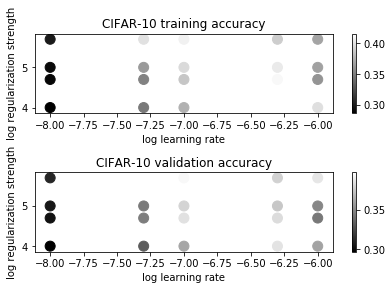

In [130]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.show()

In [131]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.383500


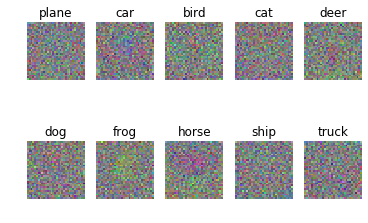

In [132]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

theta = best_svm.theta[:-1,:] # strip out the bias
theta = theta.reshape(32, 32, 3, 10)
theta_min, theta_max = np.min(theta), np.max(theta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[:, :, :, i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])